In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

from scipy import stats
from scipy.integrate import quad

import pickle

# Data

In [2]:
#data_filename = 'data_flags_updated_Nov1.dat'
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF_updated.fits'

#catalog_SDSS = Table.read(data_filename, format='ascii')
hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

## Identify which fields are being used for which parameters

In [4]:
catalog_main.colnames

['IAUNAME',
 'SUBDIR',
 'RA',
 'DEC',
 'ISDSS',
 'INED',
 'ISIXDF',
 'IALFALFA',
 'IZCAT',
 'ITWODF',
 'MAG',
 'Z',
 'ZSRC',
 'SIZE',
 'RUN',
 'CAMCOL',
 'FIELD',
 'RERUN',
 'XPOS',
 'YPOS',
 'NSAID',
 'ZDIST',
 'SERSIC_NMGY',
 'SERSIC_NMGY_IVAR',
 'SERSIC_OK',
 'SERSIC_RNMGY',
 'SERSIC_ABSMAG',
 'SERSIC_AMIVAR',
 'EXTINCTION',
 'SERSIC_KCORRECT',
 'SERSIC_KCOEFF',
 'SERSIC_MTOL',
 'SERSIC_B300',
 'SERSIC_B1000',
 'SERSIC_METS',
 'SERSIC_MASS',
 'XCEN',
 'YCEN',
 'NPROF',
 'PROFMEAN',
 'PROFMEAN_IVAR',
 'QSTOKES',
 'USTOKES',
 'BASTOKES',
 'PHISTOKES',
 'PETRO_FLUX',
 'PETRO_FLUX_IVAR',
 'FIBER_FLUX',
 'FIBER_FLUX_IVAR',
 'PETRO_BA50',
 'PETRO_PHI50',
 'PETRO_BA90',
 'PETRO_PHI90',
 'SERSIC_FLUX',
 'SERSIC_FLUX_IVAR',
 'SERSIC_N',
 'SERSIC_BA',
 'SERSIC_PHI',
 'ASYMMETRY',
 'CLUMPY',
 'DFLAGS',
 'AID',
 'PID',
 'DVERSION',
 'PROFTHETA',
 'PETRO_THETA',
 'PETRO_TH50',
 'PETRO_TH90',
 'SERSIC_TH50',
 'PLATE',
 'FIBERID',
 'MJD',
 'RACAT',
 'DECCAT',
 'ZSDSSLINE',
 'SURVEY',
 'PROGRAMNAME

In [5]:
# ra,dec,z
ra = np.array(catalog_main['RA']) #np.array(data['ra'])
dec = np.array(catalog_main['DEC']) #np.array(data['dec'])
z = np.array(catalog_main['Z']) #np.array(data['redshift'])

# stellar mass
#Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])

# color
u_r = np.array(catalog_main['u_r_KIAS']) #np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))]
u_r_NSA = np.array(catalog_main['u_r']) #np.array(data['u_r_NSA'])
#g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 
g_r_NSA = np.array(catalog_main['g_r']) #np.array(data['g_r_NSA'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4]) #np.array(data['rabsmag_NSA'])

#star formation rate and specific SPR
SFR  = np.array(catalog_main['SFR']) #np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 
sSFR = np.array(catalog_main['sSFR']) #np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))]

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_28869/912260125.py:9: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS']) #np.array(data['Mstar_NSA'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Result plots

In [8]:
def char_void(char_, bins_, title='galaxy property', label='x-label'):
    '''
    Plots a histogram for a galaxy characterstic for void galaxies only 
    for both algorithms
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space) 
        histogram bins
    '''
    char_void_vf = char_[void_vf]
    char_void_v2 = char_[void_v2]
    
    fig, ax = plt.subplots(figsize=(10, 6)) # 8,4
    
#     plt.hist(char_void_vf, label = 'Voidfinder void galaxies' ,bins= bins_,alpha = 0.6, density = True, color='green')
#     plt.hist(char_void,  label = 'V^2 void galaxies',bins= bins_, color = 'blue',alpha = 0.4, density = True)
#     plt.hist(char_[data['redshift']< 0.1026],  label = 'All galaxies',bins= bins_, color = 'gray',alpha = 0.6, density = True)

#     plt.legend()
#     plt.title(title)
#     plt.xlabel(label)    
    
#     plt.savefig('figures/'+title+".png")
#     plt.show()
    
    
    counts_void_vf, bins_void_vf = np.histogram(char_void_vf, bins= bins_)
    counts_void_v2, bins_void_v2 = np.histogram(char_void_v2, bins= bins_)
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], bins= bins_)
    
    counts_void_vf = np.array(counts_void_vf)/len(char_void_vf)
    counts_void_v2 = np.array(counts_void_v2)/len(char_void_v2)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    
    ax.hist(bins_void_vf[:-1], 
            bins=bins_void_vf, 
            weights=counts_void_vf, 
            label = 'Voidfinder void galaxies' , 
            color='red', 
            histtype='step')
    ax.hist(bins_void_v2[:-1], 
            bins=bins_void_v2, 
            weights=counts_void_v2,
            label = r'$V^{2}$ void galaxies', 
            color = 'blue',
            histtype='step')
    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all, 
            label = 'All', 
            color = 'gray',
            alpha = 0.2)
    
    
    ax.legend(fontsize=14)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=20)
    ax.set_ylabel(r"Fraction of galaxies", fontsize=20)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
        
#     plt.savefig('figures/'+title+".png")
#     plt.show()

In [41]:
def char(char_, 
         bins_, 
         title='galaxy property', 
         label='x-label', 
         voidfinder=False,
         x=None,
         y=None):
    '''
    Plots a histogram for a galaxy characterstic for wall and void galaxies
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space)
        histogram bins
    
    voidfinder : (bool) 
        True if the classification comes from the VoidFinder algorithm, 
        False if it comes from V^2
    
    x : 
        x coordinate of the location of the algorithm's name
    
    y :
        y coordinate of the location of the algorithm's name
    '''
    
    if voidfinder:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    
    fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
    
    fig.patch.set_facecolor('none')
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], 
                                        bins= bins_)
    
    
    counts_wall = np.array(counts_wall)/len(char_wall)
    counts_void = np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    
    '''
    if voidfinder:
        color_wall='black'
        color_void='red'
    else:
        color_wall='blue'
        color_void='green'
    '''
    color_wall = 'black'
    color_void = 'red'
    
    ax.hist(bins_void[:-1], 
            bins=bins_void, 
            weights=counts_void ,
            label = 'Void', 
            color = color_void,
            histtype='step', 
            linewidth=2)
    ax.hist(bins_wall[:-1], 
            bins=bins_wall, 
            weights=counts_wall, 
            label = 'Wall' , 
            color=color_wall, 
            histtype='step',
            linestyle='dotted', 
            linewidth=2)
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all,  
            label = 'All', 
            color = 'gainsboro', 
            ec='gainsboro')
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel("Fraction of galaxies", fontsize=24)
    
#     plt.title(title, fontsize=18)
    if voidfinder:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    if label in ['Absolute Magnitude', 'Absolute Magnitude - NSA', '$M_r$']:
        ax.set_xlim(-12, -24)
        ax.set_ylim(0, 0.0275)
    elif label in [r'$\log(M_*/M_\odot)$']:
        ax.set_ylim(0, 0.045)
    elif label in [r'$u-r$']:
        ax.set_ylim(0, 0.02)
    elif label in [r'$g-r$']:
        ax.set_ylim(0, 0.0375)
    elif label in ['SFR [log($M_\odot$/yr)]']:
        ax.set_ylim(0, 0.013)
    elif label in ['sSFR [log(yr$^{-1}$)]']:
        ax.set_ylim(0, 0.015)
        
    # plt.tight_layout()
    
    #plt.savefig('figures/'+title+".eps", format='eps', dpi=300)
    plt.savefig('figures/'+title+'.png', format='png', dpi=300)
#     plt.show()

In [10]:
def char_unnorm(char_, 
                bins_, 
                title='galaxy property', 
                label='x-label', 
                voidfinder=False,
                x=None,
                y=None):
    '''
    Plots an unnormalized histogram for a galaxy characterstic for wall and void galaxies
    
    PARAMETERS
    ==========
    
    char_ : (numpy array)
        charachteristic of galaxy desired for plotting
    
    bins_ : (numpy linear space)
        histogram bins
    
    voidfinder : (bool) 
        True if the classification comes from the VoidFinder algorithm, 
        False if it comes from V^2
    
    x : 
        x coordinate of the location of the algorithm's name
    
    y :
        y coordinate of the location of the algorithm's name
    '''
    
    if voidfinder:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[catalog_main['Z']< 0.114], 
                                        bins= bins_)
    
    '''
    counts_wall = np.array(counts_wall)/len(char_wall)
    counts_void = np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[catalog_main['Z']< 0.114])
    '''
    '''
    if voidfinder:
        color_wall='black'
        color_void='red'
    else:
        color_wall='blue'
        color_void='green'
    '''
    color_wall = 'black'
    color_void = 'red'
    
    ax.hist(bins_void[:-1], 
            bins=bins_void, 
            weights=counts_void ,
            label = 'Void', 
            color = color_void,
            histtype='step', 
            linewidth=2)
    ax.hist(bins_wall[:-1], 
            bins=bins_wall, 
            weights=counts_wall, 
            label = 'Wall' , 
            color=color_wall, 
            histtype='step',
            linestyle='dotted', 
            linewidth=2)
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], 
            bins=bins_all, 
            weights=counts_all,  
            label = 'All', 
            color = 'gainsboro', 
            ec='gainsboro')
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=18)
    ax.set_xlabel(label, fontsize=24)
    ax.set_ylabel("Number of galaxies", fontsize=24)
    
#     plt.title(title, fontsize=18)
    if voidfinder:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    if label in ['Absolute Magnitude', 'Absolute Magnitude - NSA', '$M_r$']:
        ax.set_xlim(-12, -24)
        
    plt.tight_layout()
    
#     plt.savefig('figures/'+title+"_unnorm.eps", format='eps', dpi=300)
#     plt.show()

## Stellar mass

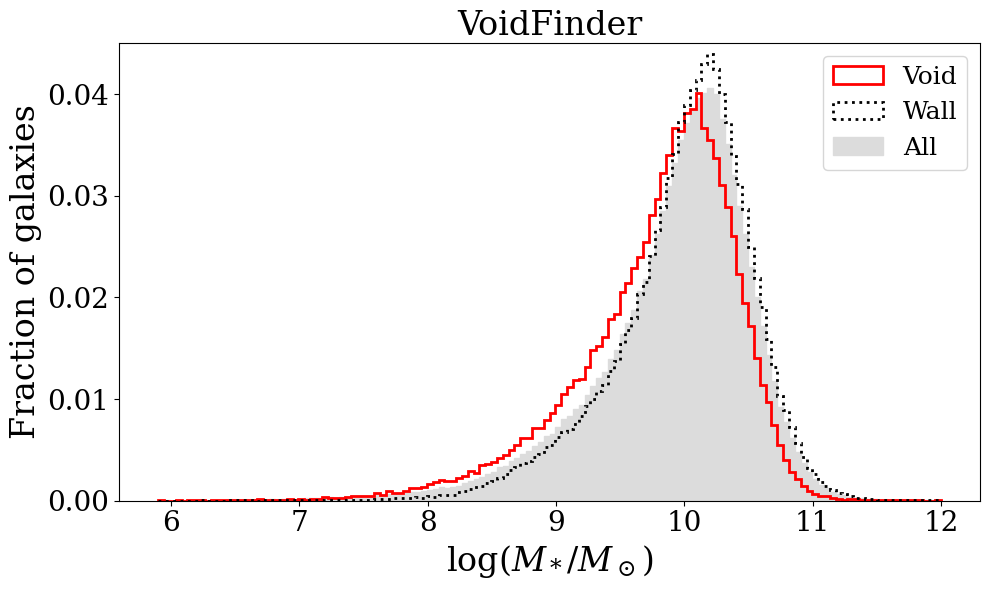

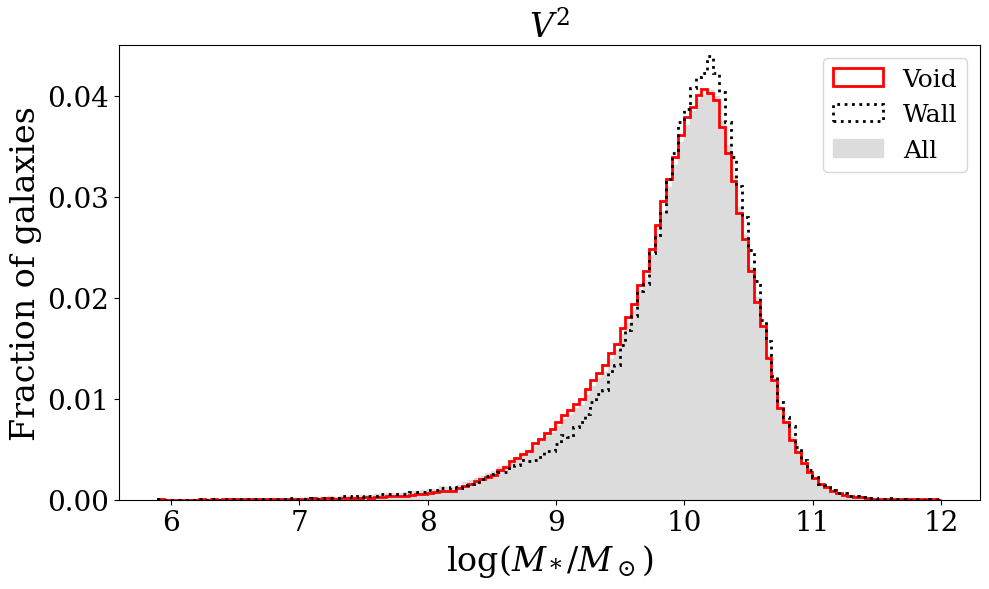

In [17]:
char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_VF_NSA',
     r'$\log(M_*/M_\odot)$',
     voidfinder=True,
     x=6,
     y=0.025)

char(Mstar_NSA,
     np.linspace(5.9,12, 135),
     'Mstar_hist_V2_NSA',
     r'$\log(M_*/M_\odot)$',
     x=6,
     y=0.025)

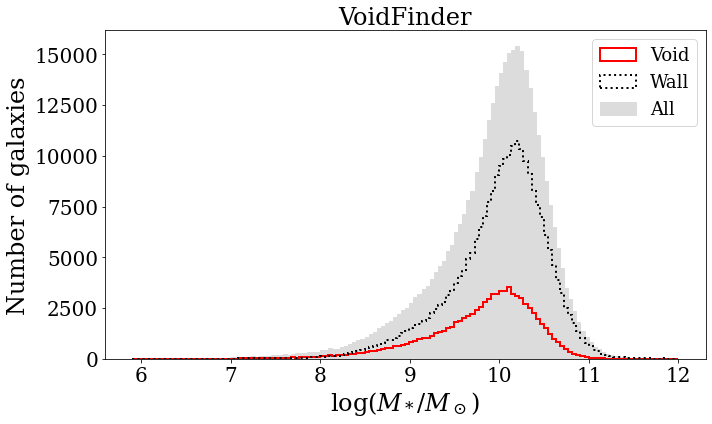

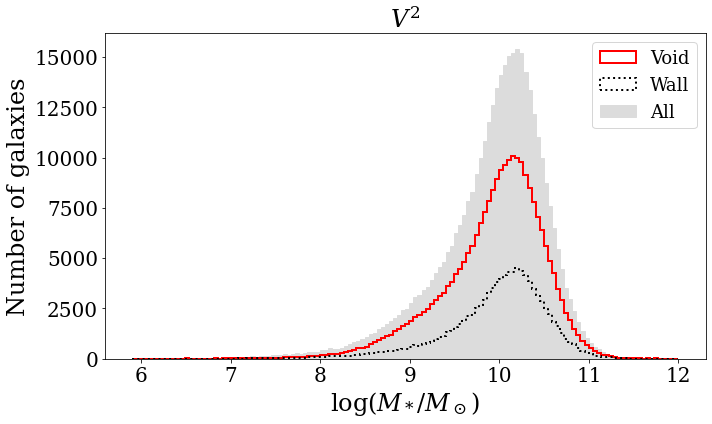

In [11]:
char_unnorm(Mstar_NSA,
            np.linspace(5.9,12, 135),
            'Mstar_hist_VF_NSA',
            r'$\log(M_*/M_\odot)$',
            voidfinder=True,
            x=6,
            y=0.025)

char_unnorm(Mstar_NSA,
            np.linspace(5.9,12, 135),
            'Mstar_hist_V2_NSA',
            r'$\log(M_*/M_\odot)$',
            x=6,
            y=0.025)

## Color

### $u-r$

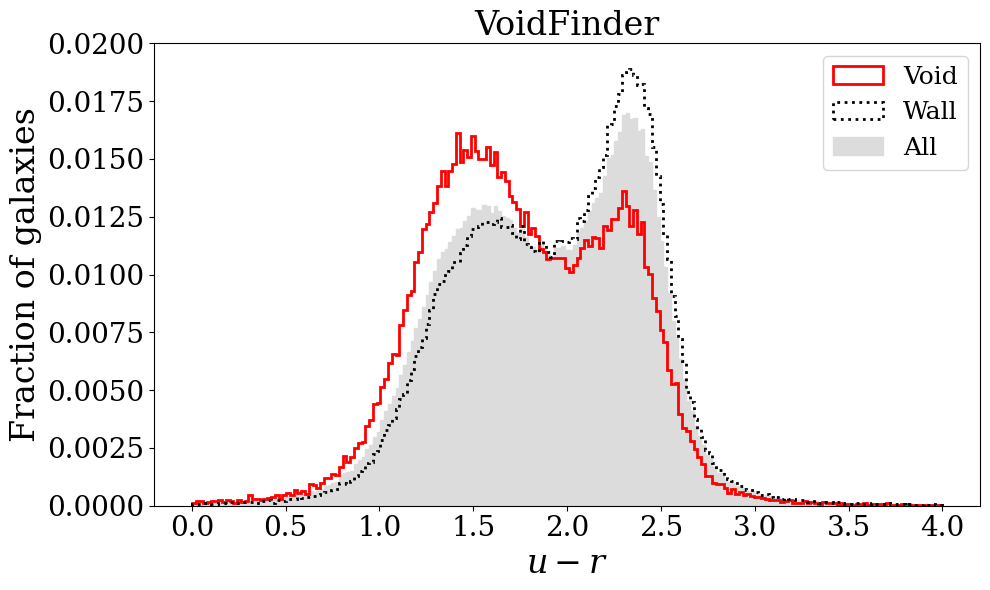

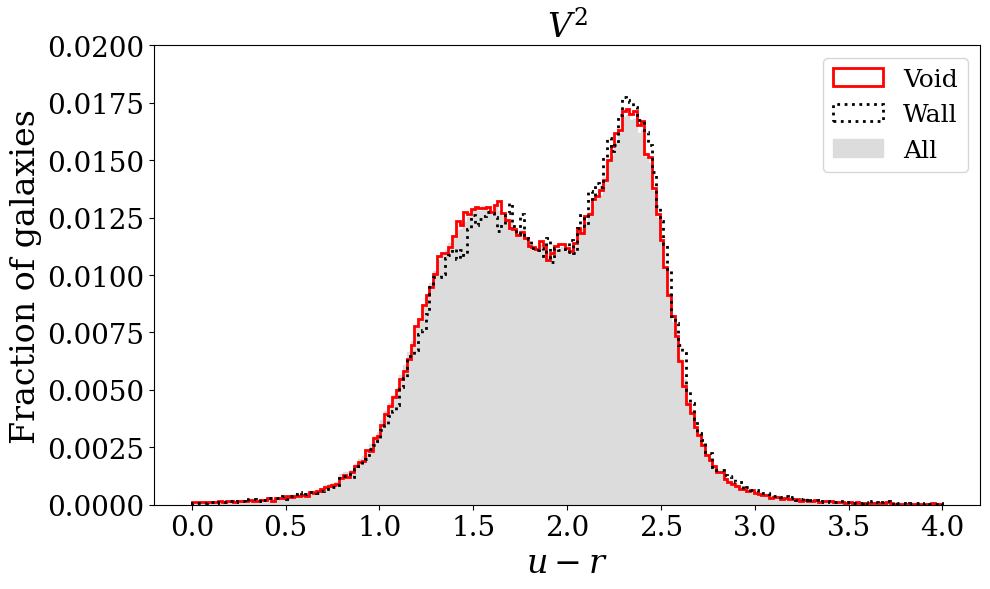

In [19]:
char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_VF_NSA',
     r'$u-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)

char(u_r_NSA, 
     np.linspace(0,4, 200),
     'u-r_hist_V2_NSA',
     r'$u-r$', 
     x=0.2,
     y=0.016)

#### Color u-r - NSA

The conclusions from VF are in line with the literature that indicates that void galaxies are retarded in their star formation because they evolve in an environment with fewer interactions (mergers, tidal stripping etc) compared to wall galaxies.

$V^2$ does not make the same prediction because it grows voids farther into the walls which leads to the contamination of the classification

### $g-r$ 

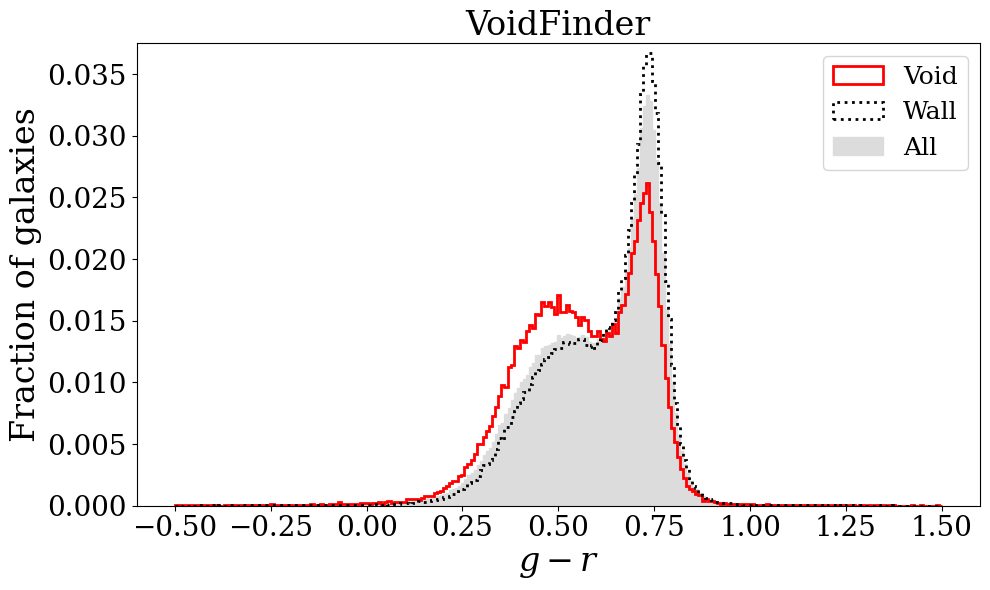

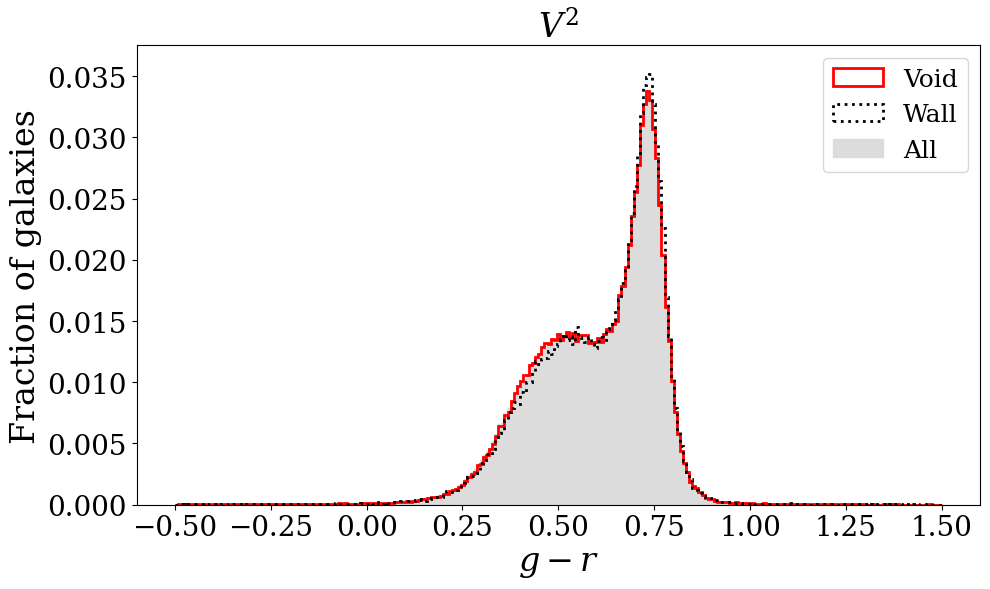

In [22]:
char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_VF_NSA',
     r'$g-r$', 
     voidfinder = True,
     x=0.2,
     y=0.016)

char(g_r_NSA, 
     np.linspace(-0.5,1.5, 250),
     'g-r_hist_V2_NSA',
     r'$g-r$', 
     x=0.2,
     y=0.016)

## Absolute magnitude

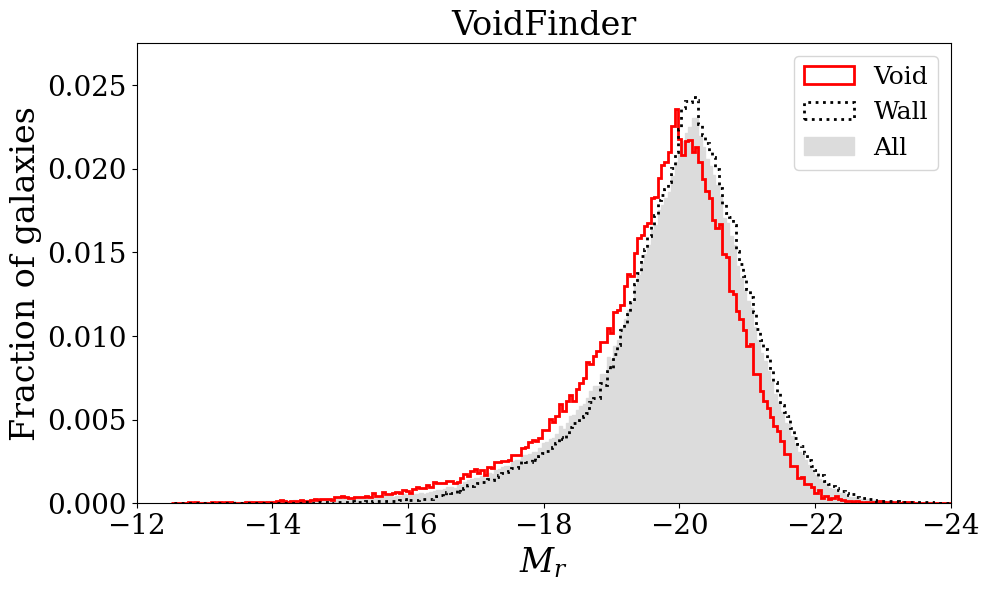

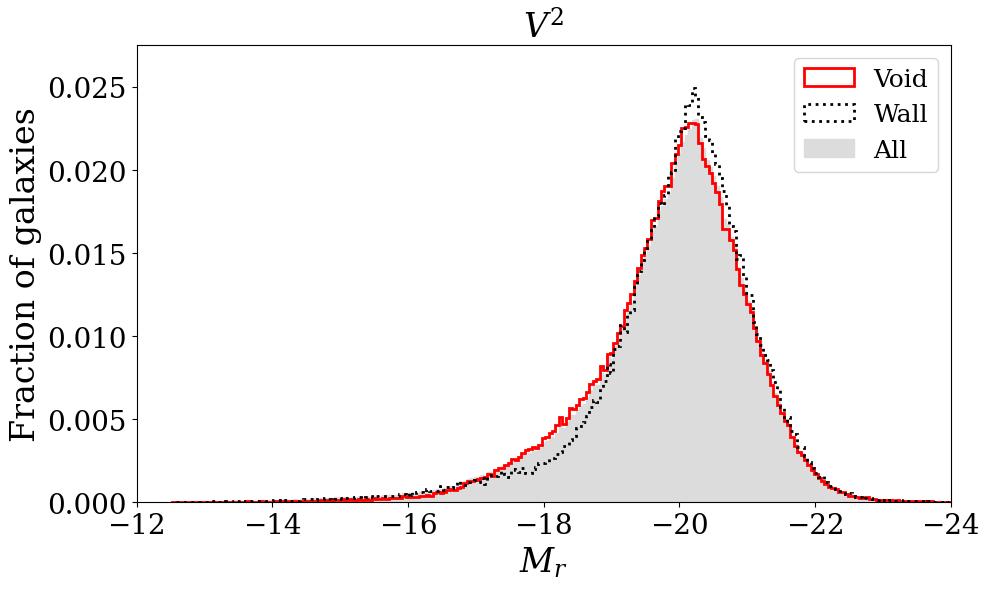

In [28]:
char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_VF_NSA',
     '$M_r$', 
     voidfinder=True,
     x=-13,
     y=0.023)

char(rabsmag_NSA,
     np.linspace(-25,-12.5, 250),
     'rabsmag_hist_V2_NSA',
     '$M_r$',
     x=-13,
     y=0.023)

## Star Formation Rate

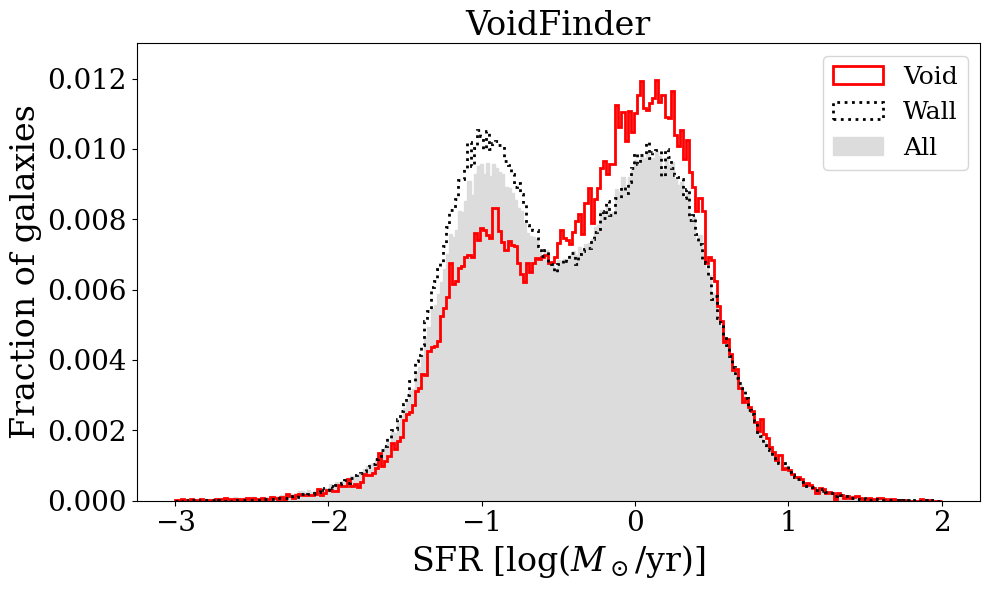

In [34]:
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_VF_NSA',
     'SFR [log($M_\odot$/yr)]', 
     voidfinder = True,
     x=-2.7,
     y=0.012)

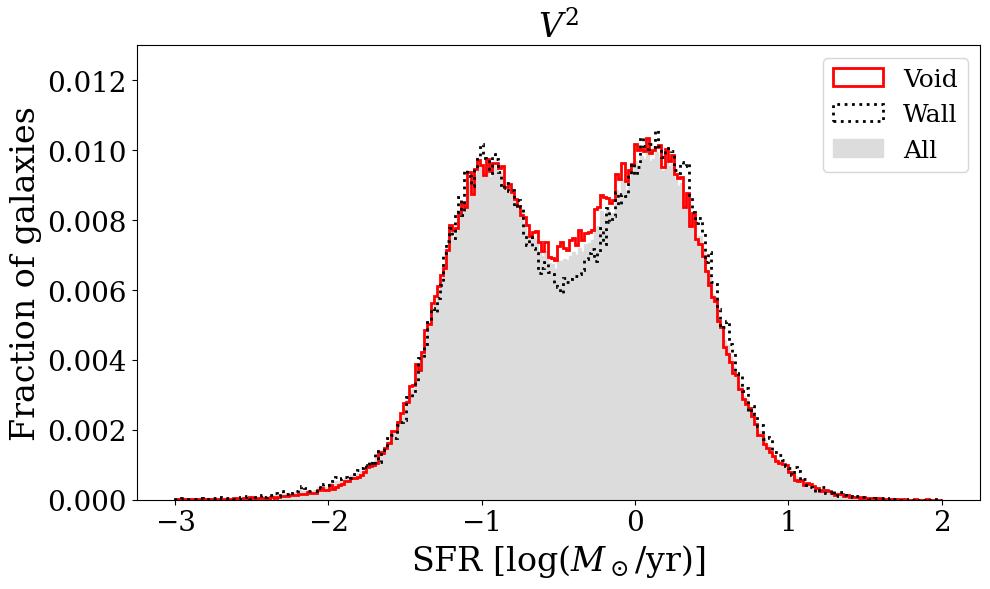

In [35]:
char(SFR,
     np.linspace(-3,2, 250),
     'SFR_hist_V2_NSA',
     'SFR [log($M_\odot$/yr)]',
     x=-2.7,
     y=0.0105)

## Specific Star Formation Rate

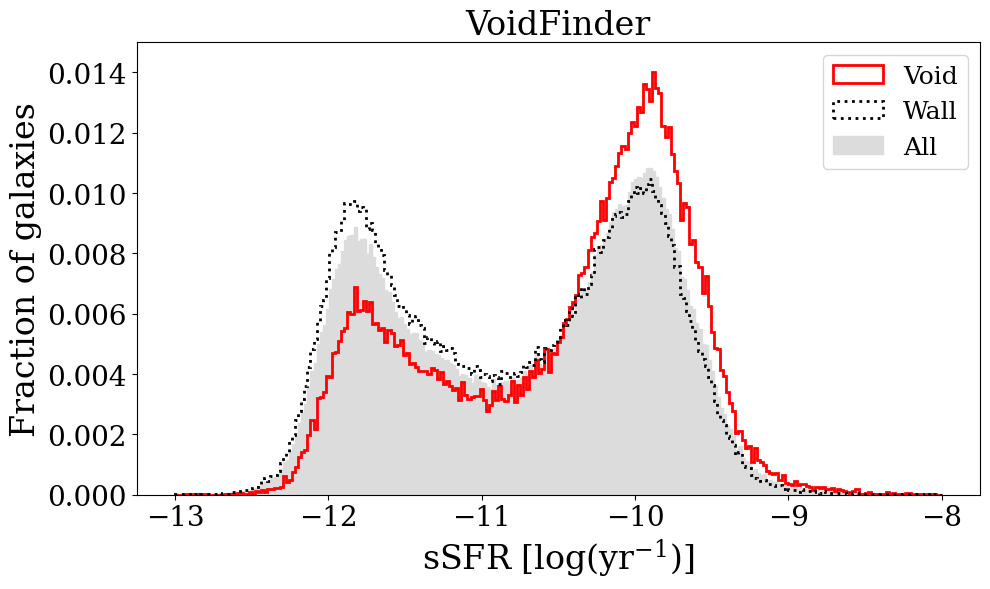

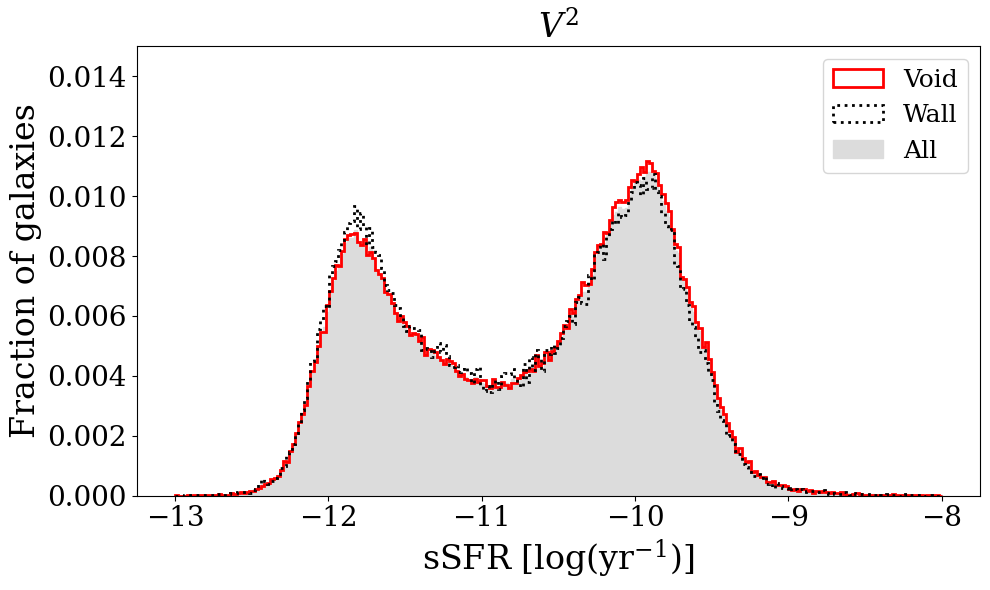

In [42]:
char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_VF_NSA',
     'sSFR [log(yr$^{-1}$)]', 
     voidfinder = True,
     x=-12.7,
     y=0.013)

char(sSFR,
     np.linspace(-13,-8, 250),
     'sSFR_hist_V2_NSA',
     'sSFR [log(yr$^{-1}$)]',
     x=-12.7,
     y=0.0105)

# CDFs

## M$_*$

In [43]:
def CDF_plot(x, prop, VF=False):
    '''
    Plot the CDF of the data in x for the void, wall, and overall populations.
    
    
    PARAMETERS
    ==========
    
    x : ndarray of shape (N,)
        Data values of the property to create the CDF of
        
    prop : string
        Name of property that is being plotted.  This will be the x-axis label.
        
    VF : boolean
        Whether or not to plot VoidFinder's (True) or V2 (False).
    '''
    
    # Remove all non-real values
    finite_boolean = np.isfinite(x)
    
    # For all galaxies, only use the same redshift limit as those in the galaxy set
    z_boolean = catalog_main['Z'] <= 0.114
    
    all_x = sorted(x[z_boolean & finite_boolean])
    all_y = np.arange(len(x[z_boolean & finite_boolean]))/len(x[z_boolean & finite_boolean])
    
    if VF:
        void_x = sorted(x[void_vf & finite_boolean])
        wall_x = sorted(x[wall_vf & finite_boolean])
        
        void_y = np.arange(len(x[void_vf & finite_boolean]))/len(x[void_vf & finite_boolean])
        wall_y = np.arange(len(x[wall_vf & finite_boolean]))/len(x[wall_vf & finite_boolean])
    
    else:
        void_x = sorted(x[void_v2 & finite_boolean])
        wall_x = sorted(x[wall_v2 & finite_boolean])
        
        void_y = np.arange(len(x[void_v2 & finite_boolean]))/len(x[void_v2 & finite_boolean])
        wall_y = np.arange(len(x[wall_v2 & finite_boolean]))/len(x[wall_v2 & finite_boolean])
        
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.tick_params(labelsize=20)
        
    ax.plot(all_x, all_y, c='gainsboro', linewidth=2, label='SDSS DR7')
    ax.plot(void_x, void_y, 'r', linewidth=2, label='Void')
    ax.plot(wall_x, wall_y, 'k:', linewidth=2, label='Wall')
    
    ax.set_xlabel(prop, fontsize=24)
    ax.set_ylabel('Fraction', fontsize=24)
    
    if VF:
        ax.set_title('VoidFinder', fontsize=24)
    else:
        ax.set_title('$V^2$', fontsize=24)
    
    ax.legend(fontsize=18)

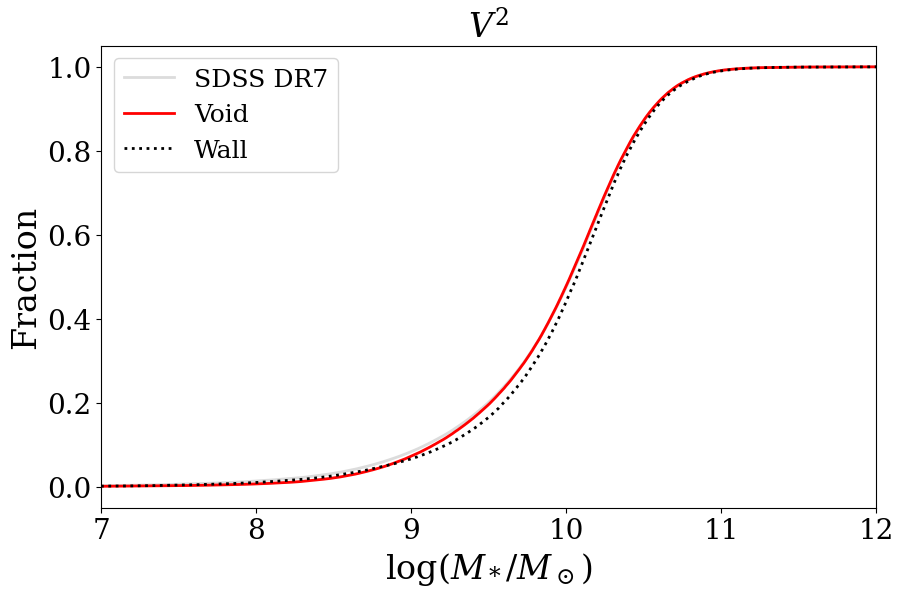

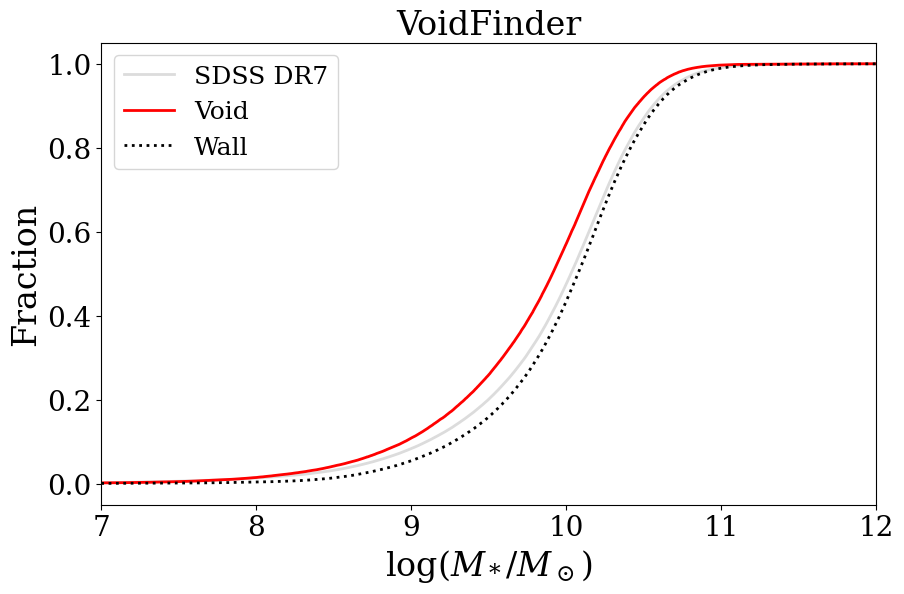

In [44]:
CDF_plot(Mstar_NSA, 'log($M_*/M_\odot$)')

plt.xlim([7,12])

CDF_plot(Mstar_NSA, 'log($M_*/M_\odot$)', VF=True)

plt.xlim([7,12]);

## Luminosity

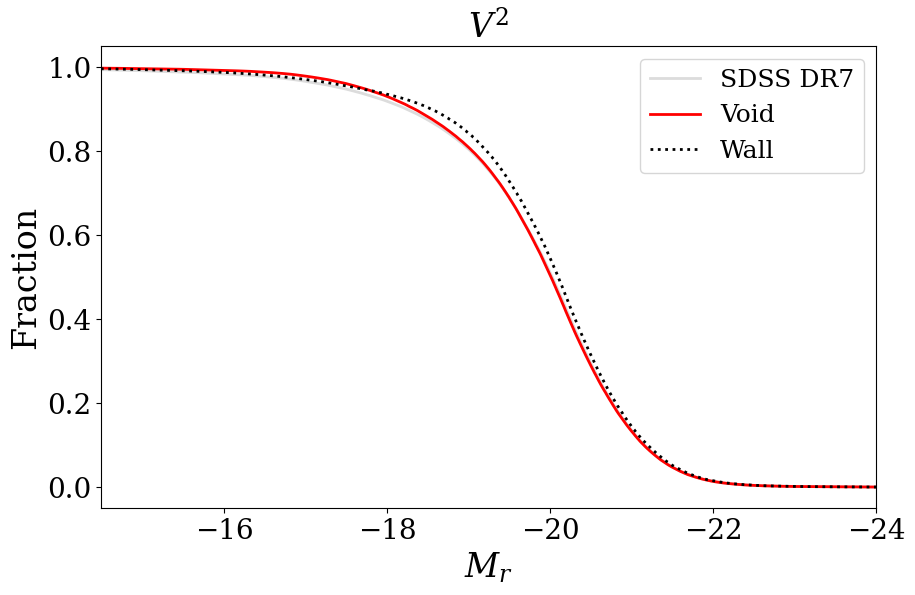

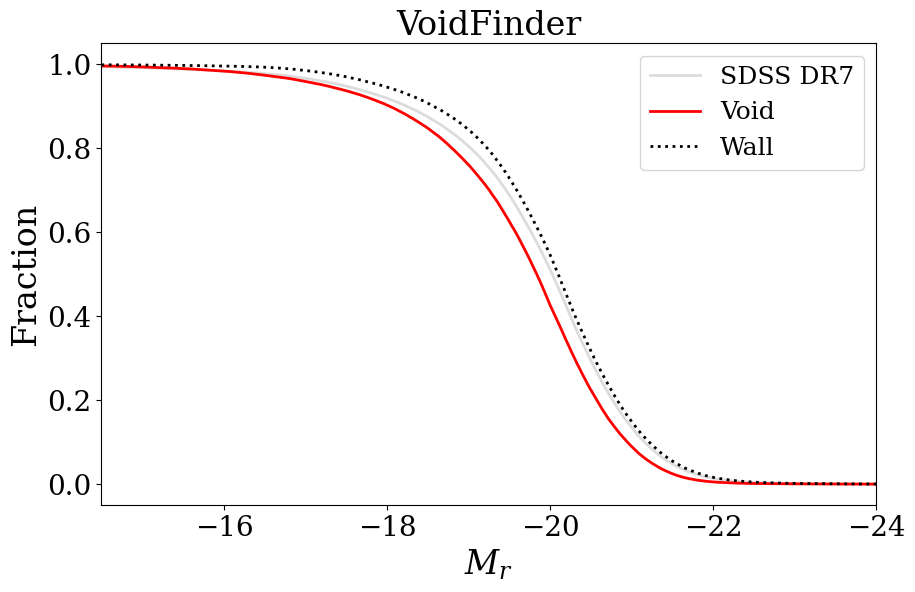

In [45]:
CDF_plot(rabsmag_NSA, '$M_r$')

plt.xlim([-14.5,-24])

CDF_plot(rabsmag_NSA, '$M_r$', VF=True)

plt.xlim([-14.5,-24]);

## Color

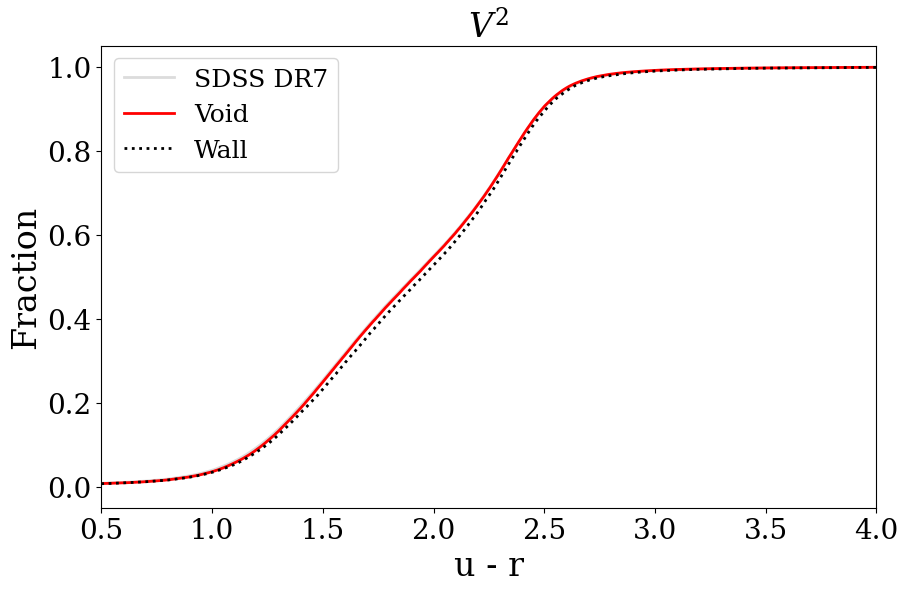

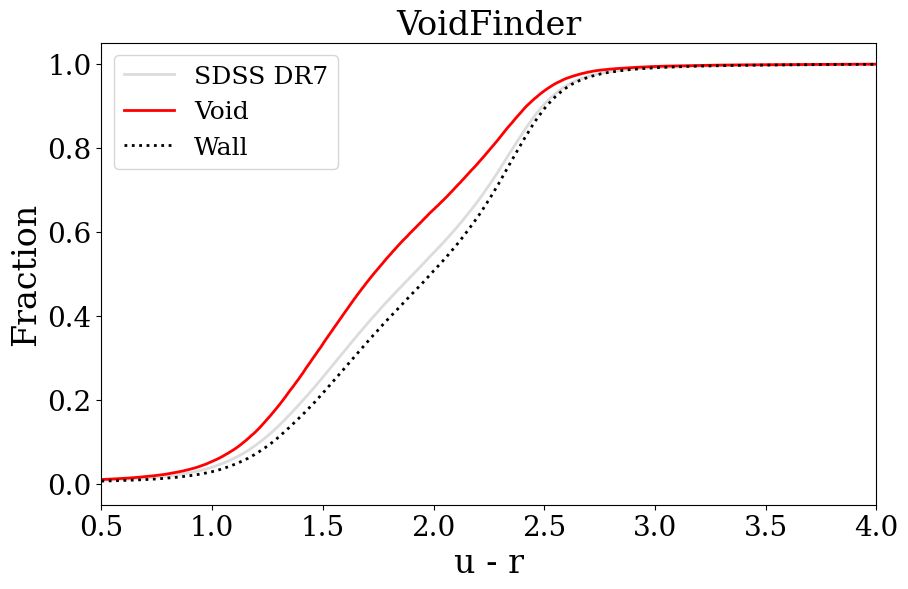

In [46]:
CDF_plot(u_r_NSA, 'u - r')

plt.xlim([0.5,4])

CDF_plot(u_r_NSA, 'u - r', VF=True)

plt.xlim([0.5,4]);

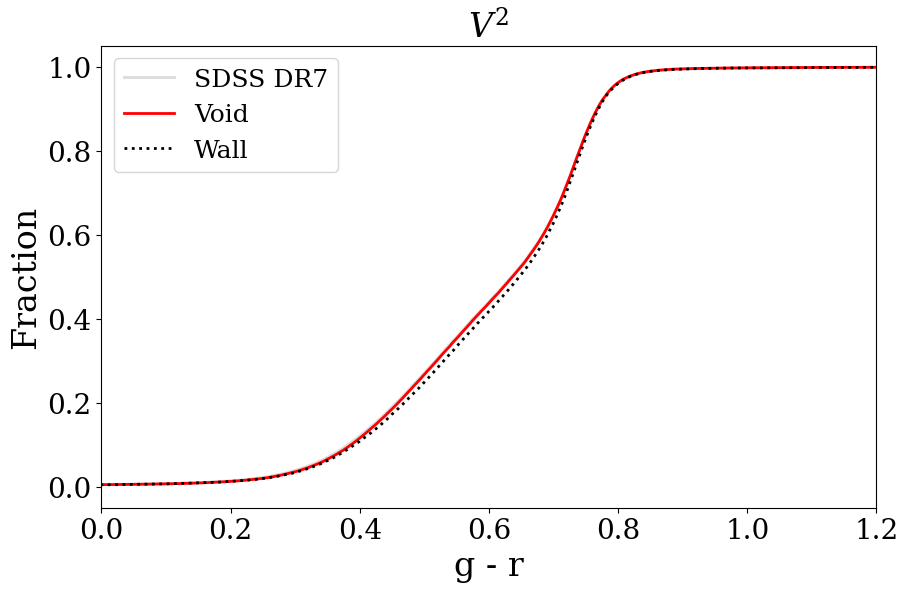

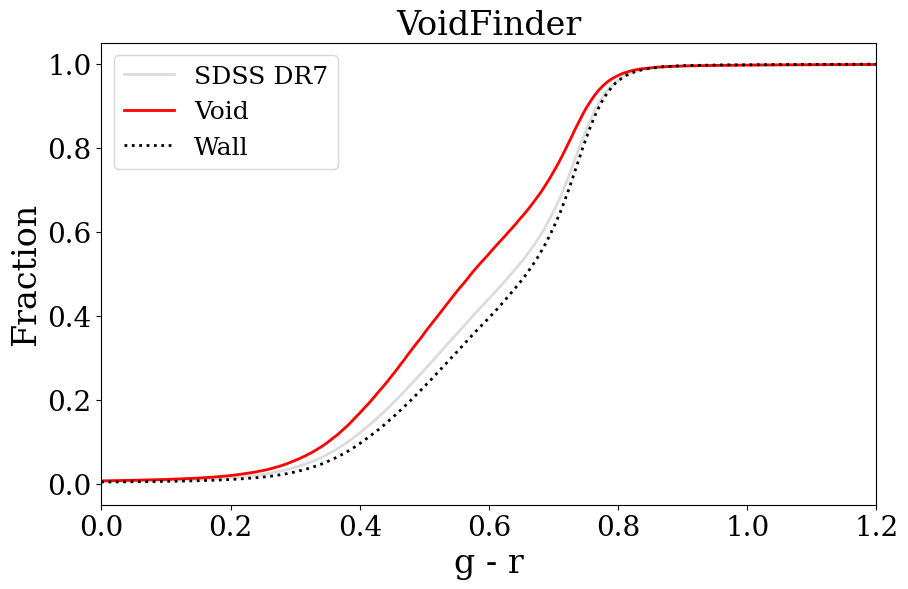

In [47]:
CDF_plot(g_r_NSA, 'g - r')

plt.xlim([0,1.2])

CDF_plot(g_r_NSA, 'g - r', VF=True)

plt.xlim([0,1.2]);

## SFR

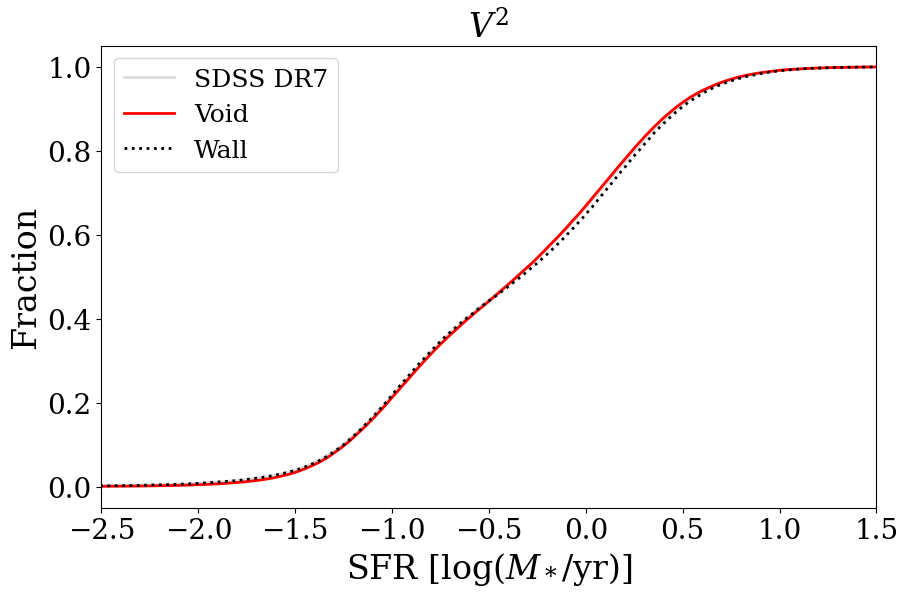

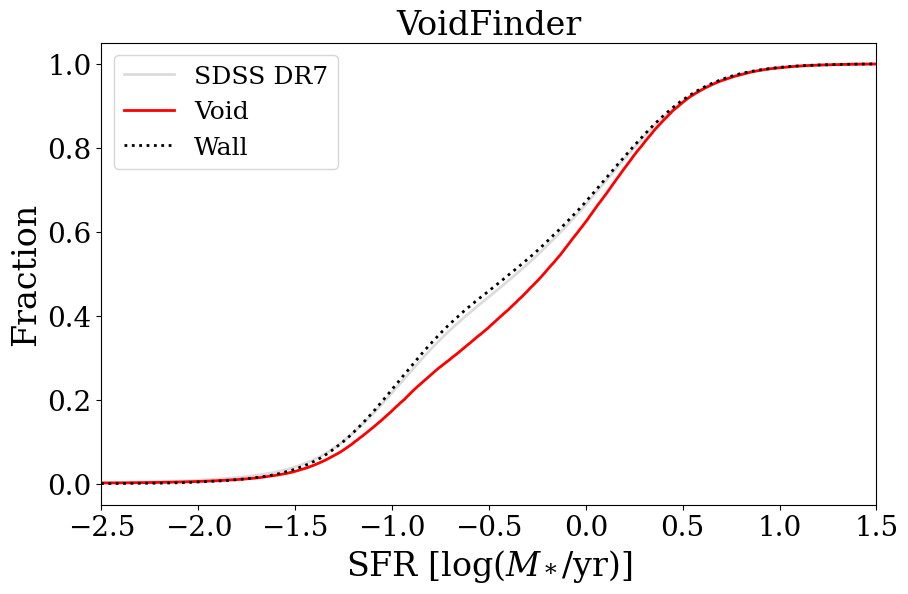

In [48]:
CDF_plot(SFR, 'SFR [log($M_*$/yr)]')

plt.xlim([-2.5,1.5])

CDF_plot(SFR, 'SFR [log($M_*$/yr)]', VF=True)

plt.xlim([-2.5,1.5]);

## sSFR

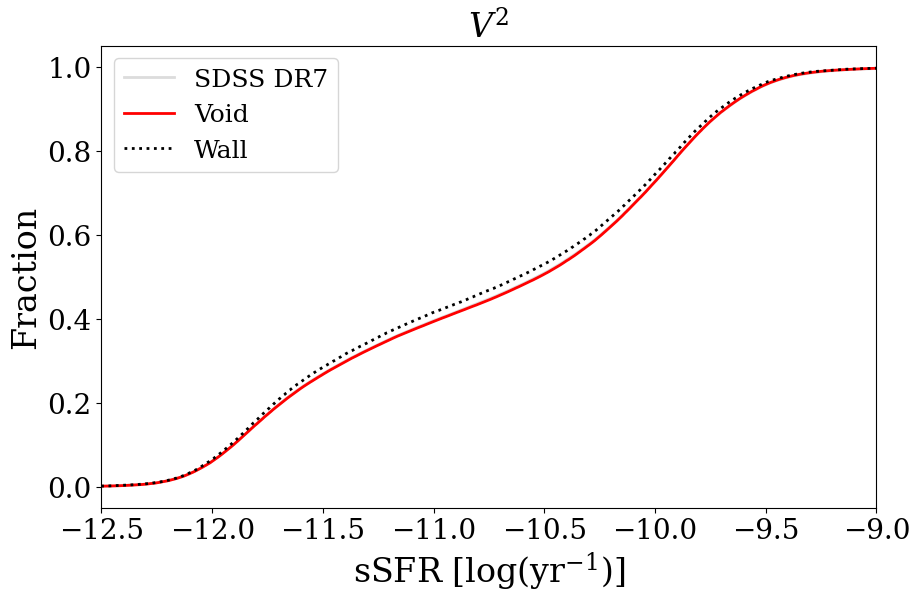

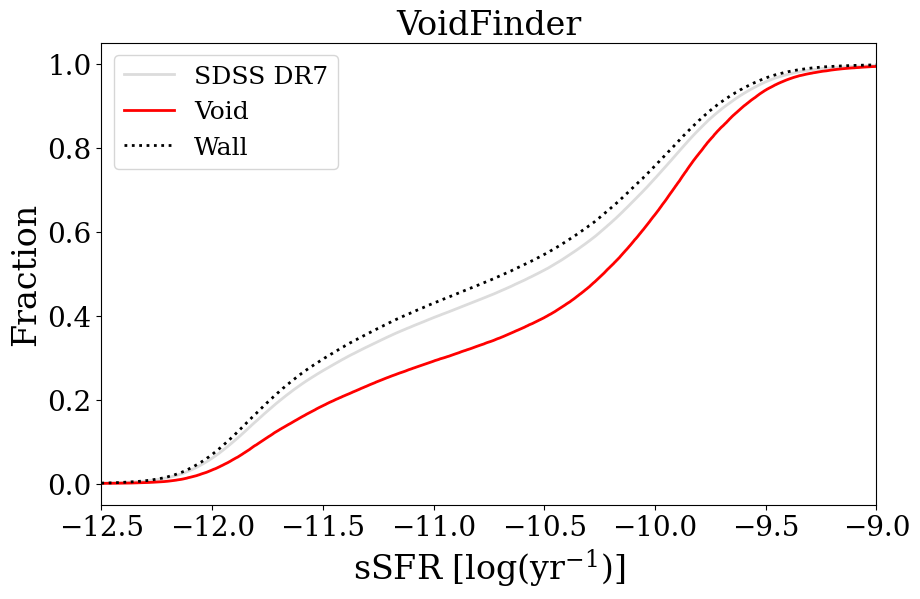

In [49]:
CDF_plot(sSFR, 'sSFR [log(yr$^{-1}$)]')

plt.xlim([-12.5,-9])

CDF_plot(sSFR, 'sSFR [log(yr$^{-1}$)]', VF=True)

plt.xlim([-12.5,-9]);